# File structure

This project assumes the following initial file structure:

```
.\main                       
|   applicationsPlots.ipynb  
|   applicationsData.json    
|   environment.yml          
|                            
\---images                   
    ...                      
```

# Modules

## Imports

In [1]:
import importlib.metadata
import json
import os
import types
from collections import defaultdict
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from matplotlib.colors import CSS4_COLORS
from matplotlib.dates import date2num

## Versions

The current module versions in use are as follows:

In [2]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

installed_packages = {dist.metadata["Name"]: dist.version for dist in importlib.metadata.distributions()}

requirements = [
    (name, installed_packages[name])
    for name in imports
    if name in installed_packages and name != "pip"
]


pd.DataFrame(requirements, columns=["Module", "Version"])

,Module,Version
0,plotly,5.24.1
1,matplotlib,3.9.2
2,pandas,2.2.3


# Global variables

The following global variables are used throughout the entirety of the methodology section.

In [3]:
APPLICATION_DATA_PATH = os.path.join("data", "applications.json")
PLOTS_PATH = "plots"
DEFAULT_STEP_LABELS = [
    "Company Website",
    "Email",
    "Career Fair",
    "LinkedIn",
    "Initial Screening",
    "Technical Assessment",
    "First-Round Interview",
    "Technical Interview",
    "Second-Round Interview",
    "No Answer",
    "Rejected",
    "Offer Received",
    "Declined"
]

# Sankey Diagram
GOOD_COLOR = "lightgreen"
AVERAGE_COLOR = "orange"
AVERAGE_NODES = ["No Answer", "Declined"]
BAD_COLOR = "red"
BAD_NODES = ["Rejected"]

# Main

## Sankey Diagram

In [4]:
def css_color_to_rgba(color_name, alpha):
    try:
        hex_value = CSS4_COLORS[color_name.lower()]
        rgb = tuple(int(hex_value[i : i + 2], 16) for i in (1, 3, 5))
        rgba = (*rgb, alpha)
        return f"rgba{rgba}"
    except KeyError:
        return None

def create_neighbor_pairs(input_list):
    return [(input_list[i], input_list[i + 1]) for i in range(len(input_list) - 1)]

In [5]:
def plot_sankey_diagram(
    pad=20,
    application_data_path=APPLICATION_DATA_PATH,
    plots_path=None,
    default_step_labels=DEFAULT_STEP_LABELS,
    good_color=GOOD_COLOR,
    average_color=AVERAGE_COLOR,
    bad_color=BAD_COLOR,
):
    with open(application_data_path, "r") as f:
        applications = json.load(f)

    step_labels = default_step_labels
    link_counts = defaultdict(int)
    for application in applications:
        for step in application["process"]:
            if step not in step_labels:
                step_labels.append(step)
        application["links"] = [
            (application["process"][index], application["process"][index + 1])
            for index in range(len(application["process"]) - 1)
        ]
        for link in application["links"]:
            link_counts[link] += 1

    node_color_map = {
        node: (
            BAD_COLOR
            if node in BAD_NODES
            else AVERAGE_COLOR if node in AVERAGE_NODES else GOOD_COLOR
        )
        for node in step_labels
    }

    node = dict(
        label=step_labels, pad=pad, thickness=15, color=list(node_color_map.values())
    )

    link_labels = list(link_counts.keys())
    link = dict(
        source=[step_labels.index(source_label) for [source_label, _] in link_labels],
        target=[step_labels.index(target_label) for [_, target_label] in link_labels],
        value=list(link_counts.values()),
        color=[
            css_color_to_rgba(node_color_map[target_label], alpha=0.5)
            for [_, target_label] in link_labels
        ],
    )

    sankey = go.Sankey(link=link, node=node, arrangement="snap")
    fig = go.Figure(data=[sankey])

    fig.update_layout(
        title_text="Sankey Applications",
        font=dict(size=12),
        title_font=dict(size=22),
        title_x=0.5,
    )

    if plots_path:
        fig.write_html(os.path.join(plots_path, "sankey_diagram.html"))

    fig.show()

In [6]:
plot_sankey_diagram(
    pad=40, plots_path=PLOTS_PATH
)

## Gantt Chart

In [7]:
def plot_gantt(
    application_data_path=APPLICATION_DATA_PATH,
    plots_path=None,
    alphabetical=False,
    group_by_company=True,
    max_length=50,
    figsize=(12, 8),
):
    applications = pd.read_json(application_data_path)
    applications["updates"] = applications["updates"].apply(
        lambda x: list(pd.to_datetime(x, format="%d/%m/%Y"))
    )
    applications["update_num"] = applications["updates"].apply(date2num)

    if group_by_company:
        grouping_column = "company"
    else:
        applications["identifier"] = (
            applications["company"] + " - " + applications["position"]
        ).str.slice(0, max_length)
        grouping_column = "identifier"

    if alphabetical:
        applications = applications.sort_values(by=grouping_column).reset_index(
            drop=True
        )
        identifiers = list(applications[grouping_column].unique())
    else:
        if group_by_company:
            merged_data = applications.groupby(grouping_column, as_index=False).agg(
                {
                    "updates": lambda x: sorted(
                        set(date for sublist in x for date in sublist)
                    )
                }
            )
            merged_data["updates"] = merged_data["updates"].apply(
                lambda dates: list(pd.to_datetime(dates, format="%d/%m/%Y"))
            )
            merged_data = merged_data.sort_values(by="updates")

            identifiers = list(merged_data[grouping_column])
        else:
            applications = applications.sort_values(by="updates")
            identifiers = list(applications[grouping_column])

    fig, ax = plt.subplots(figsize=figsize, dpi=80)

    colormap = plt.get_cmap("tab20", len(identifiers))
    for index, application in applications.iterrows():
        ax.plot(
            application["update_num"],
            [identifiers.index(application[grouping_column])]
            * len(application["update_num"]),
            marker="o",
            color=colormap(identifiers.index(application[grouping_column])),
            label=application[grouping_column],
        )

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%b"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

    plt.title("Gantt Chart of Application Updates", fontsize=22)
    plt.xlabel("Dates", fontsize=14)
    plt.xticks(fontsize=12, rotation=0, horizontalalignment="center", alpha=0.7)
    plt.ylabel("Positions", fontsize=14)
    plt.yticks(range(len(identifiers)))
    ax.set_yticklabels(identifiers, fontsize=12, alpha=0.7)
    plt.grid(axis="both", alpha=0.5)

    plt.tight_layout()

    if plots_path:
        fig.savefig(os.path.join(plots_path, "gantt_chart.png"))
    plt.show()

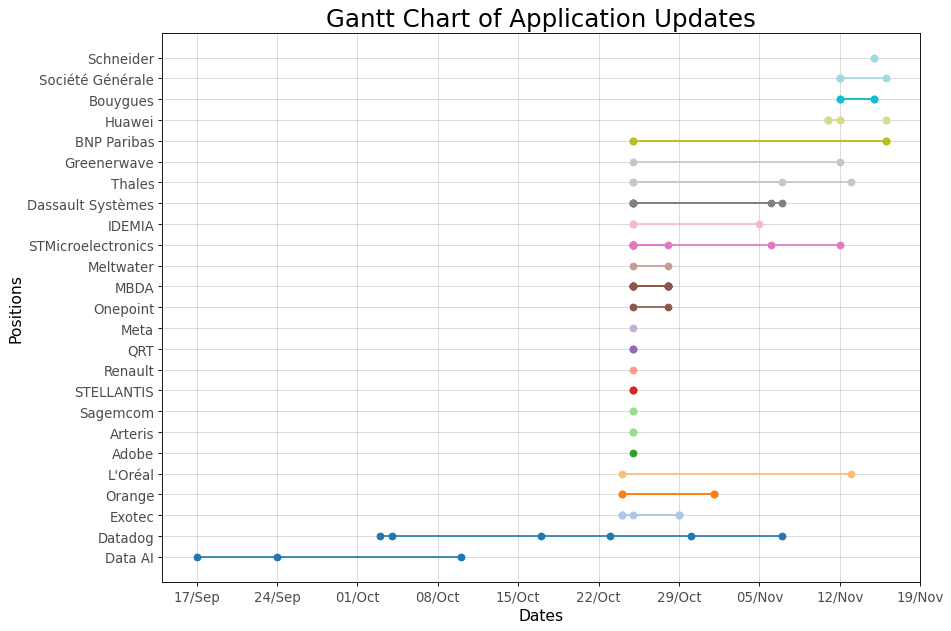

In [8]:
plot_gantt(plots_path=PLOTS_PATH)

## Bar Chart

### Source Effectiveness

In [9]:
def plot_source_effectiveness(
    application_data_path=APPLICATION_DATA_PATH,
    plots_path=None,
    good_color=GOOD_COLOR,
    average_color=AVERAGE_COLOR,
    bad_color=BAD_COLOR,
    figsize=(10, 6)
):
    applications = pd.read_json(application_data_path)

    status_counts = (
        applications["process"]
        .apply(
            lambda x: {
                "source": x[0] if len(x) > 0 else "Unknown",
                "status": (
                    "Rejected"
                    if "Rejected" in x
                    else "No Answer" if "No Answer" in x else "Other"
                ),
            }
        )
        .apply(pd.Series)
        .groupby(["source", "status"])
        .size()
        .unstack(fill_value=0)
    )

    status_counts["Total"] = status_counts.sum(axis=1)
    status_counts = status_counts.sort_values(by="Total", ascending=False).drop(
        columns=["Total"]
    )
    status_counts = status_counts[["Rejected", "No Answer", "Other"]]

    # Plot 1: Status analysis by source
    fig, ax = plt.subplots(figsize=figsize, dpi=80)

    status_counts.plot(
        ax=ax,
        kind="bar",
        stacked=True,
        color={"Other": good_color, "Rejected": bad_color, "No Answer": average_color},
    )

    plt.title("Application Status Analysis by Source", fontsize=22)
    plt.xlabel("Source", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(fontsize=12, rotation=0, horizontalalignment="center", alpha=0.7)
    plt.yticks(fontsize=12, alpha=0.7)
    plt.legend(title="Status", loc="upper right")
    plt.grid(axis="y", alpha=0.5)
    plt.tight_layout()
    if plots_path:
        fig.savefig(os.path.join(plots_path, "status_analysis_by_source.png"))
    plt.show()

    status_by_source = status_counts.T
    status_by_source["Total"] = status_by_source.sum(axis=1)
    status_by_source = status_by_source.sort_values(by="Total", ascending=False).drop(
        columns=["Total"]
    )

    # Plot 2: Source analysis by status
    fig, ax = plt.subplots(figsize=figsize, dpi=80)

    status_by_source.plot(kind="bar", stacked=True, ax=ax)

    plt.title("Application Source Analysis by Status", fontsize=22)
    plt.xlabel("Status", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(fontsize=12, rotation=0, horizontalalignment="center", alpha=0.7)
    plt.yticks(fontsize=12, alpha=0.7)
    plt.legend(title="Source", loc="upper right")
    plt.grid(axis="y", alpha=0.5)
    plt.tight_layout()
    if plots_path:
        fig.savefig(os.path.join(plots_path, "source_analysis_by_status.png"))
    plt.show()

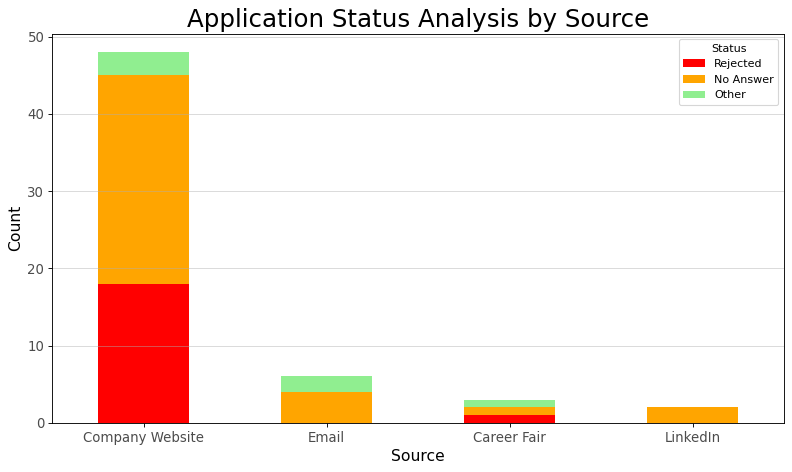

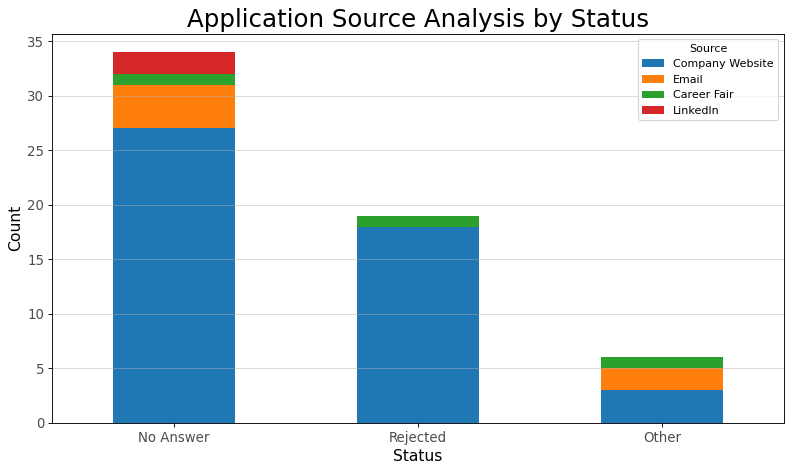

In [10]:
plot_source_effectiveness(plots_path=PLOTS_PATH)